In [0]:
import os
import sys
import random
import math
import re
import time
import numpy as np

!pip install keras==2.0.8
!pip install tensorflow==1.15.0
import tensorflow as tf
import keras
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 文件的根目录
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

# 参数与预训练模型的文件目录
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

%matplotlib inline 
# 预训练模型的权重
COCO_MODEL_PATH = "/content/drive/My Drive/Colab Notebooks/mask_rcnn_coco.h5"

#  COCO Dataset
import coco
config = coco.CocoConfig()

# 将训练的配置重写为带有测试的更改
class InferenceConfig(config.__class__):
    # 一次一张图像的检测
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
# 加载神经网络的设备
# 训练时使用GPU,测试时使用CPU
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0
# 检查模型在 training 或 inference modes
# values: 'inference' or 'training'
# TODO: 若为 'training' 则不能用于测试
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# 定义COCO dataset的类别名
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 
        'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
        'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 
        'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 
        'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
        'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 
        'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
        'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
        'teddy bear', 'hair drier', 'toothbrush']

In [0]:
# 加载模型
# 创建用于测试的模型
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
weights_path = COCO_MODEL_PATH

# 加载权重
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/drive/My Drive/Colab Notebooks/mask_rcnn_coco.h5


proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 81)         min:    0.00000  max:    0.99976  float32
deltas                   shape: (1, 1000, 81, 4)      min:   -3.53729  max:    3.80575  float32
masks                    shape: (1, 100, 28, 28, 81)  min:    0.00002  max:    0.99989  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:   28.00000  float32
19 detections: ['person' 'person' 'person' 'person' 'person' 'person' 'person' 'person'
 'person' 'person' 'person' 'person' 'person' 'person' 'person' 'person'
 'person' 'tie' 'tie']
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 81)         min:    0.00000  max:    0.99963  float32
deltas                   shape: (1, 1000, 81, 4)      min:   -3.48455  max:    3.26748  float32
masks                    shape: (1, 100, 28, 28,

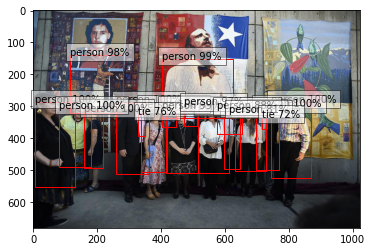

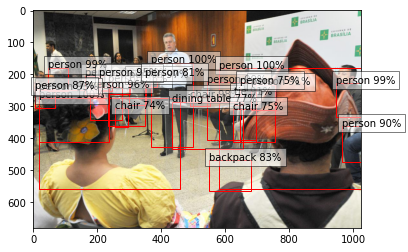

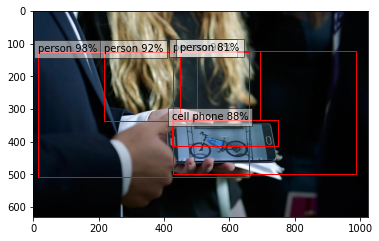

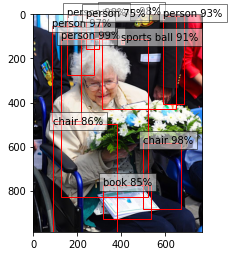

In [0]:
# 在预训练模型上运行分类器，以生成类可能性和边界框回归
import matplotlib.image as mpimg # mpimg 用于读取图片
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# 用于规范化所得边界框box的大小
def denorm_boxes(boxes, shape):
    """Converts boxes from normalized coordinates to pixel coordinates.
    boxes: [N, (y1, x1, y2, x2)] in normalized coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [N, (y1, x1, y2, x2)] in pixel coordinates
    """
    h, w = shape
    scale = np.array([h - 1, w - 1, h - 1, w - 1])
    shift = np.array([0, 0, 1, 1])
    return np.around(np.multiply(boxes, scale) + shift).astype(np.int32)
# 加载图片
folder = "/content/drive/My Drive/test_image/"
list_of_test_data = [f for f in os.listdir(folder) if f.endswith('.jpg')]
list_of_test_data = [folder + image_path for image_path in list_of_test_data]
for image_path in list_of_test_data:
  image = mpimg.imread(image_path)
  fig, ax = plt.subplots(1)
  ax.imshow(image)
  # 输入图片数据，得到分类结果以及mask的输出
  mrcnn = model.run_graph([image], [
      ("proposals", model.keras_model.get_layer("ROI").output),
      ("probs", model.keras_model.get_layer("mrcnn_class").output),
      ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
      ("masks", model.keras_model.get_layer("mrcnn_mask").output),
      ("detections", model.keras_model.get_layer("mrcnn_detection").output),
  ])
  # 得到检测结果class IDs，修改zero padding.
  det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
  det_count = np.where(det_class_ids == 0)[0][0]
  det_class_ids = det_class_ids[:det_count]
  detections = mrcnn['detections'][0, :det_count]

  print("{} detections: {}".format(
      det_count, np.array(class_names)[det_class_ids]))
  for detection in detections:
    box = denorm_boxes(detection[:4], image.shape[:2])
    bot, left, top, right = box
    x, y, w, h = [val for val in [left, bot, right - left, top - bot]]
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, "{} {:.0f}%".format(class_names[int(detection[4])], detection[5]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

In [0]:
"""另外一种标注结果的方式


# 在预训练模型上运行分类器，以生成类可能性和边界框回归
import matplotlib.image as mpimg # mpimg 用于读取图片
# 加载测试图片
folder = "/content/drive/My Drive/test_image/"
list_of_test_data = [f for f in os.listdir(folder) if f.endswith('.jpg')]
list_of_test_data = [folder + image_path for image_path in list_of_test_data]
for image_path in list_of_test_data:
  image = mpimg.imread(image_path)
  # 输入图片数据，得到分类结果以及mask的输出
  mrcnn = model.run_graph([image], [
      ("proposals", model.keras_model.get_layer("ROI").output),
      ("probs", model.keras_model.get_layer("mrcnn_class").output),
      ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
      ("masks", model.keras_model.get_layer("mrcnn_mask").output),
      ("detections", model.keras_model.get_layer("mrcnn_detection").output),
  ])
  # 得到检测结果class IDs，修改zero padding.
  det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
  det_count = np.where(det_class_ids == 0)[0][0]
  det_class_ids = det_class_ids[:det_count]
  detections = mrcnn['detections'][0, :det_count]

  print("{} detections: {}".format(
      det_count, np.array(class_names)[det_class_ids]))

  captions = ["{} {:.3f}".format(class_names[int(c)], s) if c > 0 else ""
              for c, s in zip(detections[:, 4], detections[:, 5])]
  visualize.draw_boxes(
      image, 
      refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
      visibilities=[2] * len(detections),
      captions=captions, title="Detections",
      ax=get_ax())"""

Output hidden; open in https://colab.research.google.com to view.

In [0]:
print(bot,left,top,right)

0.0059813187 0.3118935 0.15724784 0.38726968
